In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import Input, Model
#from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [6]:
def read_data():
    os.chdir('D:/TU_Graz/Thesis/Datasets/Reddit_features')
    train = pd.read_csv("train_final_all.csv")
    test = pd.read_csv("test_final_all.csv")
    data = train.append(test)
    
    return train, test, data

In [7]:
def create_lists(data, category):
    words = list(set(data["Token"].values))
    words.append("ENDPAD")
    n_words = len(words)
    tags = list(set(data[category].values))
    n_tags = len(tags)
    
    return words, n_words, tags, n_tags

In [8]:
def group_sentences(data, category):
    all_sents = []
    sent_ids = data['Sent_id'].unique()
    for curr_id in sent_ids:
        tmp_df = data[data['Sent_id'] == curr_id]
        tmp_df = pd.concat([tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:149], tmp_df[category]], axis = 1)
        records = tmp_df.to_records(index=False)
        all_sents.append(records)
    return all_sents

In [9]:
def remove_sents_over_threshold(sents, threshold):
    sentences = list()
    for s in sents:
        if len(s) < threshold:
            sentences.append(s)
    return sentences

In [10]:
def prepare_and_pad(sentences, max_len, word2idx, tag2idx):
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = n_words - 1)

    y = [[tag2idx[w[len(w)-1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=n_tags) for i in y]
    
    return X, y

In [11]:
def build_model(max_len, n_words, n_tags):
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.3))(model)  # variational biLSTM
    out = Dense(n_tags, activation="softmax")(model) 
    model = Model(input, out)
    return model 

In [12]:
def plot_learning_curves(hist, curve1, curve2):
    plt.figure(figsize=(6,6))
    plt.plot(hist[curve1])
    plt.plot(hist[curve2])
    plt.show()

In [13]:
def evaluate_test_data(model, X_test, y_test):
    p = model.predict(np.array(X_test))
    p = np.argmax(p, axis=-1)
    y_test = np.array(y_test)
    y_test = np.argmax(y_test, axis=-1)

    y_orig = []
    for sent in y_test:
        for tag in sent:
            y_orig.append(tag)
        
    y_preds = []
    for sent in p:
        for tag in sent:
            y_preds.append(tag)    

    report = classification_report(y_orig, y_preds)
    print(report)

Loading the data...
Creating sets of words and tags...
Creating sentence list...
Removing submissions longer than threshold...
Creating word and tag maps...
Padding data...
Building the model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          2922900   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 300)         541200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 300, 17)           5117     

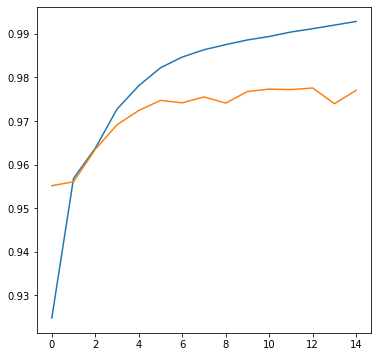

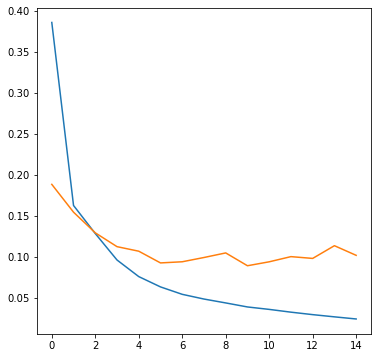

Test the model...
12/12 [==============================] - 9s 741ms/step


C:\Users\Kiki\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.24      0.11      0.15        37
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00         4
           3       0.12      0.06      0.08        33
           4       0.72      0.85      0.78       214
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        32
           8       0.38      0.20      0.27       456
           9       0.85      0.76      0.80      1409
          10       0.93      0.87      0.90        46
          11       0.33      0.04      0.06        28
          12       0.88      0.78      0.82      1814
          13       0.00      0.00      0.00        21
          14       0.99      1.00      0.99    104277
          15       0.40      0.04      0.07        56
          16       0.54      0.32      0.40       750

    accuracy                           0.98    109200
   macro avg       0.40   

In [14]:
print("Loading the data...")
train, test, data = read_data()

print("Creating sets of words and tags...")
words, n_words, tags, n_tags = create_lists(data, "BIO")

print("Creating sentence list...")
sents = group_sentences(data, 'BIO')

print("Removing submissions longer than threshold...")
sentences = remove_sents_over_threshold(sents, 300)

print("Creating word and tag maps...")
max_len = 300
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print("Padding data...")
X, y = prepare_and_pad(sentences, max_len, word2idx, tag2idx)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

print("Building the model...")
model = build_model(max_len, n_words, n_tags)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

print("Fitting the model....")
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=15, validation_split=0.2, verbose=2)
hist = pd.DataFrame(history.history)

print("Plotting learning curves...")
plot_learning_curves(hist, "accuracy", "val_accuracy")
plot_learning_curves(hist, "loss", "val_loss")

print("Test the model...")
evaluate_test_data(model, X_test, y_test) 

print("Output predictions for a random example...")
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_test[i], p[0]):
    if(words[w] != 'ENDPAD'):
        print("{:15}: {}".format(words[w], tags[pred]))